# Success In Online Education: Random Forest Classification

In [1]:
import pickle
import numpy as np
import pandas as pd
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score
from sklearn.decomposition import PCA
from rfpimp import *
import collections as c
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='darkgrid')
plt.style.use('ggplot')
font = {'size'   : 30}
plt.rc('font', **font)
plt.ion()
plt.rcParams["patch.force_edgecolor"] = True
plt.rcParams["figure.figsize"] = (20.0, 10.0)
%matplotlib inline
pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 2000)
import warnings
warnings.filterwarnings('ignore')

In [2]:
rf_model = pickle.load(open('random_forest_completion_first_quarter.p', 'rb')) # load the model

In [3]:
rf_model.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>

In [4]:
def standard_confusion_matrix(y_true, y_pred):
    """Make confusion matrix with format:
                  -----------
                  | TP | FP |
                  -----------
                  | FN | TN |
                  -----------
    Parameters
    ----------
    y_true : ndarray - 1D
    y_pred : ndarray - 1D

    Returns
    -------
    ndarray - 2D
    """
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred, labels=[0,1])
    return np.array([[tp, fp], [fn, tn]])

def print_roc_curve(y_test, probabilities, model_type, recall):
    '''
    Calculates and prints a ROC curve given a set of test classes and probabilities from a trained classifier
    '''
    tprs, fprs, thresh = roc_curve(y_test, probabilities)
    plt.figure(figsize=(12,10))
    plt.plot(fprs, tprs, 
         label="AUC: {}\nRecall {}".format(round(roc_auc, 3), round(recall, 3)),
         color='blue', 
         lw=3)
    plt.plot([0,1],[0,1], 'k:')
    plt.legend(loc = 4, prop={'size': 30})
    plt.xlabel("FPR", fontsize=20)
    plt.ylabel("TPR", fontsize=20)
    plt.title("ROC Curve: {}".format(model_type), fontsize=40)
    
def print_confusion_matrix(conf_mat, model_name):
    '''
    Prints a formatted confusion matrix as a Seaborn heatmap with appropriate labels and titles.
    '''
    plt.figure(figsize=(10,6))
    sns.heatmap(conf_mat, annot=conf_mat, cmap='coolwarm_r', fmt='d', annot_kws={"size": 40})
    plt.xlabel('Predicted Pass        Predicted Fail', fontsize=25)
    plt.ylabel('Actual Fail      Actual Pass', fontsize=25)
    plt.title('{} Confusion Matrix'.format(model_name), fontsize=40)
    plt.show()

# def evaluate_classifier(model, t):
#     '''
#     Given a classifier and a threshold, returns key evaluation metrics
#     '''
#     predictions = (rf_model.predict_proba(X_test)[:, 1:] > t)
#     roc_auc = roc_auc_score(y_test, predictions)
#     probas = rf_model.predict_proba(X_test)[:, :1]
#     tprs, fprs, thresh = roc_curve(y_test, probas)
#     recall = recall_score(y_test, predictions, average='micro')
#     conf_mat = confusion_matrix(y_test, predictions, labels=None)
#     class_report = classification_report(y_test, predictions)
#     return predictions, roc_auc, probas, tprs, fprs, thresh, recall, conf_mat, class_report

In [5]:
X_train = pd.read_csv('../data/processed/first_quarter/X_train.csv')
y_train = pd.read_csv('../data/processed/first_quarter/y_train.csv')
y_train = y_train['module_not_completed']

X_test = pd.read_csv('../data/processed/first_quarter/X_test.csv')
y_test = pd.read_csv('../data/processed/first_quarter/y_test.csv')
y_test = y_test['module_not_completed']

# fill
X_train.fillna(value = 0, inplace = True)
X_test.fillna(value = 0, inplace = True)

In [6]:
# predictions, roc_auc, probas, tprs, fprs, thresh, recall, conf_mat, class_report = evaluate_classifier(rf_model, 0.4)

In [7]:
    t = 0.4 # threshold for predicting positive    
    predictions = (rf_model.predict_proba(X_test)[:, 1:] > t)
    roc_auc = roc_auc_score(y_test, predictions)
    probas = rf_model.predict_proba(X_test)[:, :1]
    tprs, fprs, thresh = roc_curve(y_test, probas)
    recall = recall_score(y_test, predictions, average='micro')
    conf_mat = confusion_matrix(y_test, predictions, labels=None) # sklearn way
    class_report = classification_report(y_test, predictions)

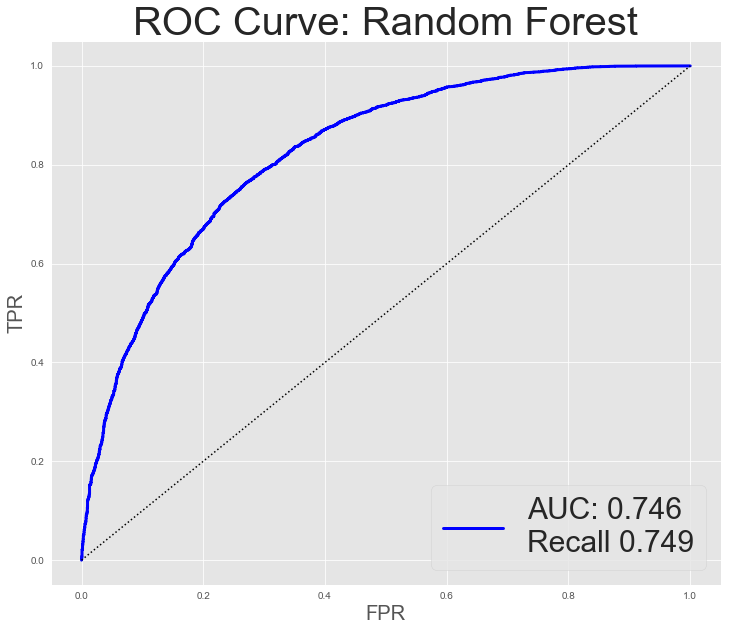

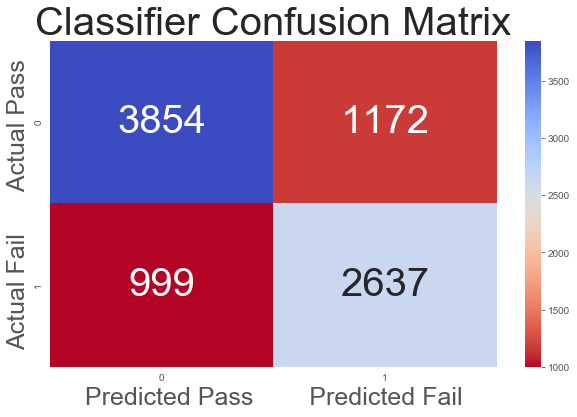


Classification Report:
               precision    recall  f1-score   support

       False       0.79      0.77      0.78      5026
        True       0.69      0.73      0.71      3636

   micro avg       0.75      0.75      0.75      8662
   macro avg       0.74      0.75      0.74      8662
weighted avg       0.75      0.75      0.75      8662



<Figure size 432x288 with 0 Axes>

In [9]:
    print_roc_curve(y_test, probas, 'Random Forest', recall)
    plt.savefig('../reports/figures/rf_roc.png')
    print_confusion_matrix(conf_mat, 'Classifier')
    plt.savefig('../reports/figures/rf_conf_mat.png')
    print('\nClassification Report:\n {}'.format(class_report))

## Model Improvement Over Baseline: Predictions Based Solely on demographics

In [10]:
bl_cols = ['gender_M', 'gender_nan', 'region_East Midlands Region', 'region_Ireland', 'region_London Region', 'region_North Region',
       'region_North Western Region', 'region_Scotland','region_South East Region', 'region_South Region', 'region_South West Region', 
        'region_Wales', 'region_West Midlands Region', 'region_Yorkshire Region', 'region_nan', 'highest_education_HE Qualification',
       'highest_education_Lower Than A Level', 'highest_education_No Formal quals', 'highest_education_Post Graduate Qualification',
       'highest_education_nan', 'imd_band_10-20', 'imd_band_20-30%', 'imd_band_30-40%', 'imd_band_40-50%', 'imd_band_50-60%',
       'imd_band_60-70%', 'imd_band_70-80%', 'imd_band_80-90%', 'imd_band_90-100%', 'imd_band_nan', 'age_band_35-55', 'age_band_55<=',
       'age_band_nan', 'disability_Y', 'disability_nan']

bl_X_train = X_train[bl_cols]
bl_X_test = X_test[bl_cols]

In [11]:
bl_model = RandomForestClassifier()

In [12]:
bl_model.fit(bl_X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [13]:
# bl_predictions, bl_roc_auc, bl_probas, bl_tprs, bl_fprs, bl_thresh, bl_recall, bl_conf_mat, bl_class_report = evaluate_classifier(bl_model, 0.5)

In [14]:
    t = 0.5 # threshold for predicting positive    
    bl_predictions = (bl_model.predict_proba(bl_X_test)[:, 1:] > t)
    bl_roc_auc = roc_auc_score(y_test, bl_predictions)
    bl_probas = bl_model.predict_proba(bl_X_test)[:, :1]
    bl_tprs, bl_fprs, bl_thresh = roc_curve(y_test, bl_probas)
    bl_recall = recall_score(y_test, bl_predictions, average='micro')
#     bl_conf_mat = standard_confusion_matrix(y_test, bl_predictions) # standard way
    bl_conf_mat = confusion_matrix(y_test, bl_predictions) # sklearn way
    bl_class_report = classification_report(y_test, bl_predictions)

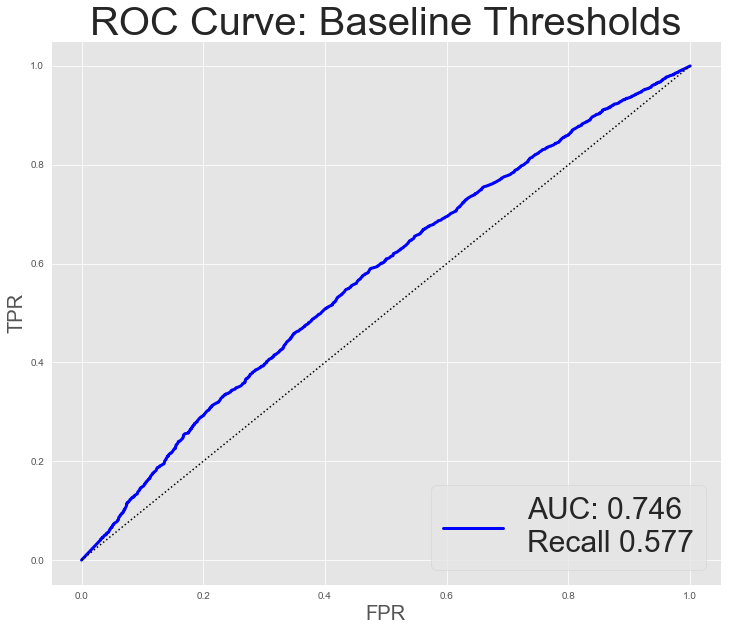

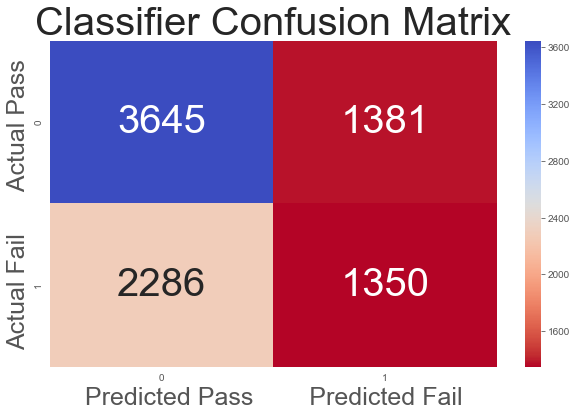


Classification Report:
               precision    recall  f1-score   support

       False       0.61      0.73      0.67      5026
        True       0.49      0.37      0.42      3636

   micro avg       0.58      0.58      0.58      8662
   macro avg       0.55      0.55      0.54      8662
weighted avg       0.56      0.58      0.56      8662



<Figure size 432x288 with 0 Axes>

In [15]:
    print_roc_curve(y_test, bl_probas, 'Baseline Thresholds', bl_recall)
    plt.savefig('../reports/figures/bl_roc.png')
    print_confusion_matrix(bl_conf_mat, 'Classifier')
    plt.savefig('../reports/figures/bl_conf_mat.png')
    print('\nClassification Report:\n {}'.format(bl_class_report))

## Permutation Feature Importance

In [ ]:
feat_imp = importances(rf_model, X_test, y_test)

In [ ]:
feat_imp[:10]

## Primary Features by Target

In [ ]:
pos = np.where(y_test == True)
neg = np.where(y_test == False)

In [ ]:
# def plot_target_hist(feature, labels, h_range=(X_test[feature].min(), X_test[feature].max()), bins=50, alpha=0.8):
#     pos = np.where(y_test == True)
#     neg = np.where(y_test == False)
#     plt.figure(figsize=(12,8))
#     plt.hist(X_test.loc[pos][feature], range=h_range, bins=bins, alpha=alpha, label=labels[0])
#     plt.hist(X_test.loc[neg][feature], range=h_range, bins=bins, alpha=alpha, label=labels[1])
#     plt.legend(prop={'size': 30})
#     plt.title(feature, fontsize=30)

In [ ]:
    plt.figure(figsize=(12,8))
    plt.hist(X_test.loc[pos]['avg_score'], range=(0, 100), bins=50, alpha=0.8, label='Fail')
    plt.hist(X_test.loc[neg]['avg_score'], range=(0, 100), bins=50, alpha=0.8, label='Pass')
    plt.legend(prop={'size': 30})
    plt.title('Avg Score', fontsize=30)
    plt.savefig('../reports/figures/avg_score_hist.png')
    plt.show()

In [ ]:
    plt.figure(figsize=(12,8))
    plt.hist(X_test.loc[pos]['sum_days_vle_accessed'], bins=50, alpha=0.8, label='Fail')
    plt.hist(X_test.loc[neg]['sum_days_vle_accessed'], bins=50, alpha=0.8, label='Pass')
    plt.legend(prop={'size': 30})
    plt.title('Sum Days VLE Accessed', fontsize=30)
    plt.savefig('../reports/figures/vle_hist.png')
    plt.show()

In [ ]:
    plt.figure(figsize=(12,8))
    plt.hist(X_test.loc[pos]['avg_days_sub_early'], bins=50, range =(-5,5), alpha=0.8, label='Fail')
    plt.hist(X_test.loc[neg]['avg_days_sub_early'], bins=50, range =(-5,5), alpha=0.8, label='Pass')
    plt.legend(prop={'size': 30})
    plt.title('Avg Days Submitted Early', fontsize=30)
    plt.savefig('../reports/figures/sub_early_hist.png')
    plt.show()

## Choosing a Threshold

In [ ]:
pd.DataFrame(data={'fprs': fprs, 'tprs': tprs, 'Thresholds': thresh}).loc[800:3487:200]

In [ ]:
    t = 0.5 # threshold for predicting positive    
    predictions = (rf_model.predict_proba(X_test)[:, 1:] > t)
    class_report = classification_report(y_test, predictions)
    plt.figure(figsize=(8,6))
    sns.heatmap(standard_confusion_matrix(y_test, predictions), annot=standard_confusion_matrix(y_test, predictions), 
                cmap='coolwarm_r', fmt='d', annot_kws={"size": 20})
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))

In [ ]:
    t = 0.4 # threshold for predicting positive    
    predictions = (rf_model.predict_proba(X_test)[:, 1:] > t)
    class_report = classification_report(y_test, predictions)
    plt.figure(figsize=(8,6))
    sns.heatmap(standard_confusion_matrix(y_test, predictions), annot=standard_confusion_matrix(y_test, predictions), 
                cmap='coolwarm_r', fmt='d', annot_kws={"size": 20})
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))

In [ ]:
    t = 0.3 # threshold for predicting positive    
    predictions = (rf_model.predict_proba(X_test)[:, 1:] > t)
    class_report = classification_report(y_test, predictions)
    plt.figure(figsize=(8,6))
    sns.heatmap(standard_confusion_matrix(y_test, predictions), annot=standard_confusion_matrix(y_test, predictions), 
                cmap='coolwarm_r', fmt='d', annot_kws={"size": 20})
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))

## Who is the model performing Poorly On?

In [ ]:
    t = 0.4 # threshold for predicting positive    
    predictions = (rf_model.predict_proba(X_test)[:, 1:] > t)

In [ ]:
correct_prediction = predictions.ravel() == y_test

In [ ]:
X_test_with_pred = X_test

In [ ]:
X_test_with_pred['correct_prediction'] = correct_prediction

In [ ]:
X_test_corr_pred = X_test_with_pred[X_test_with_pred['correct_prediction'] == True]
X_test_wrong_pred = X_test_with_pred[X_test_with_pred['correct_prediction'] == False]

In [ ]:
X_test_corr_pred.describe()

In [ ]:
X_test_wrong_pred.describe()